# Import

In [ ]:
# Import Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Install libraries
!pip install wget
!pip install jsonlines

# Import libraries
import collections
from collections import Counter, defaultdict
import numpy as np
import matplotlib.pyplot as plt
import jsonlines
import wget
import os
import re
from typing import *
from tqdm.notebook import tqdm

import torch
from torch import nn
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import SGD
torch.manual_seed(1792507)

print('Libraries imported')

  Created wheel for wget: filename=wget-3.2-cp37-none-any.whl size=9681 sha256=1721d3332c833019ddf942352ad42850b8584e41f1b5a28a231665ca7adf6b48
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget
Libraries imported


# Pre-trained Embedding

In [ ]:
# PRE-TRAINED EMBEDDING (Word2Vec Continuous Skipgram - English CoNLL17 corpus)
word_vectors = dict() # dictionary (word: -> embedding vector)
words_limit = 100_000
# path to word embedding
with open('/content/drive/MyDrive/nlp2021-hw1-main/model/word2vec.txt', 'r', encoding="ISO-8859-1") as f:
    next(f)  # skip header
    for i, line in enumerate(f):
        if i == words_limit:
            break
        word, *vector = line.strip().split(' ')
        vector = torch.tensor([float(c) for c in vector])
        word_vectors[word] = vector

# VECTORS_STORE AND WORD_INDEX TO DEAL WITH UNKNOWN AND PADDING
word_index = dict() # dictionary (word: -> index of that specific word inside vectors_store)
vectors_store = []  # array of embedding vectors, index linked to word_index dictionary

vectors_store.append(torch.rand(100))           # index = 0 -> pad token
vectors_store.append(torch.rand(100))           # index = 1 -> unk token
vectors_store.append(torch.rand(100))           # index = 2 -> separator token (between two sentences in second apporach)

for word, vector in word_vectors.items():
    word_index[word] = len(vectors_store)       # index = 3, 4 .....
    vectors_store.append(vector)                # third, forth... words

word_index = defaultdict(lambda: 1, word_index) # unknown word -> default index = 1
vectors_store = torch.stack(vectors_store)
print(vectors_store.shape)

torch.Size([100003, 100])


In [ ]:
# PLOTTING FUNCTION
def plot_logs(logs: Dict, title: str):
    # Plot training-validation loss plot
    plt.figure(figsize=(8,6))
    plt.plot(list(range(len(logs['train_loss_history']))), logs['train_loss_history'], label='Train loss')
    plt.plot(list(range(len(logs['val_loss_history']))), logs['val_loss_history'], label='Validation loss')
    plt.title(title+' loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc="upper right")
    plt.show()
    # Plot training-validation accuracy plot
    plt.figure(figsize=(8,6))
    plt.plot(list(range(len(logs['train_acc_history']))), logs['train_acc_history'], label='Train accuracy')
    plt.plot(list(range(len(logs['val_acc_history']))), logs['val_acc_history'], label='Validation accuracy')
    plt.title(title+' accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc="upper right")
    plt.show()

#First approach (word-level)

## Datasets and Dataloaders

In [ ]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, dataset_path: str):
        # data_store used to build dataloader
        self.data_store = []
        with jsonlines.open(dataset_path) as f:
            for line in f:
                self.vectorize_line(line)
                ''' each line has this kind of structure:
                {
                  "id": "dev.24",
                  "lemma": "filthy",
                  "pos": "ADJ",
                  "sentence1": "They were given food in a filthy toilet without even minimal sanitary arrangements.",
                  "sentence2": "He spent a week in a filthy cell together with seven other detainees.",
                  "start1": "26",
                  "end1": "32",
                  "start2": "21",
                  "end2": "27",
                  "label": "True"
                }
                '''

    # line -> extract features and append to data_store
    def vectorize_line(self, line):
        vector = []

        self.vectorize_sentence('sentence1', line, vector)    # vectorize and append first sentence
        vector.append(vectors_store[0])                       # pad
        self.vectorize_sentence('sentence2', line, vector)    # vectorize and append second sentence
 
        vector = torch.mean(torch.stack(vector), dim=0)       # data as mean of the vector components
        label = 0 if(line['label'] == 'False') else 1

        self.data_store.append((vector, label))

    # sentence -> extract feature of single sentence
    def vectorize_sentence (self, sentence: str, line, vector):
        for word in line[sentence].strip().split(' '):
            # ignore these characters
            word = re.sub('[\.,:;!@#$\(\)\-&\\<>/0-9"”“]', '', word).lower()
            # consider only word of 4+ characters
            if len(word) > 3:
              vector.append(vectors_store[word_index[word]])

    def __len__(self) -> int:
        return len(self.data_store)

    def __getitem__(self, idx: int) -> torch.Tensor:
        return self.data_store[idx]

In [ ]:
# Create training-validation datasets
train_dataset = MyDataset('/content/drive/MyDrive/nlp2021-hw1-main/data/train.jsonl')
validation_dataset = MyDataset('/content/drive/MyDrive/nlp2021-hw1-main/data/dev.jsonl')
# Create training-validation dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=32)
validation_dataloader = DataLoader(validation_dataset, batch_size=32)

for batch in train_dataloader:
    X, y = batch
    print(f"batch X shape: {X.shape}")
    print(f"batch y shape: {y.shape}")
    break
for batch in validation_dataloader:
    X, y = batch
    print(f"batch X shape: {X.shape}")
    print(f"batch y shape: {y.shape}")
    break

batch X shape: torch.Size([32, 100])
batch y shape: torch.Size([32])
batch X shape: torch.Size([32, 100])
batch y shape: torch.Size([32])


## Training

In [ ]:
class MyClassifier(torch.nn.Module):
    def __init__(self, n_features: int, n_hidden: int):
        super().__init__()
        # Linear layers
        self.lin1 = torch.nn.Linear(n_features, n_hidden)
        self.lin2 = torch.nn.Linear(n_hidden, n_hidden//2)
        self.lin3 = torch.nn.Linear(n_hidden//2, n_hidden//4)
        self.lin4 = torch.nn.Linear(n_hidden//4, n_hidden//8)
        self.lin5 = torch.nn.Linear(n_hidden//8, 1)
        # Dropout layer
        self.drop = torch.nn.Dropout(0.4)
        # Binary classification task -> Binary cross-entropy loss function
        self.loss_fn = torch.nn.BCELoss()

    def forward(self, x: torch.Tensor, y: Optional[torch.Tensor] = None) -> Dict[str, torch.Tensor]:
        # Network structure
        out = self.lin1(x)
        out = torch.relu(out)
        out = self.drop(out)
        out = self.lin2(out)
        out = torch.relu(out)
        out = self.drop(out)
        out = self.lin3(out)
        out = torch.relu(out)
        out = self.drop(out)
        out = self.lin4(out)
        out = torch.relu(out)
        out = self.drop(out)
        out = self.lin5(out).squeeze(1)
        # Binary classification task -> Sigmoid activation function
        out = torch.sigmoid(out)

        result = {'pred': out}

        # If we have labels, loss computation
        if y is not None:
            loss = self.loss(out, y)
            result['loss'] = loss
        return result

    def loss(self, pred, y):
        return self.loss_fn(pred, y)

In [ ]:
def training_loop(model: nn.Module, optimizer: torch.optim.Optimizer,  adapt: Callable[[torch.Tensor, torch.Tensor], Tuple[torch.Tensor, torch.Tensor]], epochs: int = 5):
    # A good accuracy from where we start saving the model (-inf is also okay)
    max_valid_acc = 0.6
    # Histories to use in plotting
    train_acc_history = []
    train_loss_history = []
    val_acc_history = []
    val_loss_history = []
    
    for epoch in range(epochs):
      # TRAINING
      losses = []
      n = 0
      d = 0
      for x, y in train_dataloader:
          if torch.cuda.is_available():
              x, y = x.cuda(), y.cuda() # sent to gpu
          x, y = adapt(x, y)
          optimizer.zero_grad()
          batch_out = model(x, y)
          train_loss = batch_out['loss']
          losses.append(train_loss)
          train_pred = torch.round(batch_out['pred'])
          d += train_pred.shape[0]
          n += (y == train_pred).int().sum()
          # training step
          train_loss.backward()
          optimizer.step()
      # Metrics computation
      train_mean_loss = sum(losses)/len(losses)
      train_loss_history.append(train_mean_loss.item())
      train_accuracy = n/d
      train_acc_history.append(train_accuracy.item())

      # EPOCH VALIDATION
      losses = []
      n = 0
      d = 0
      model.eval()
      with torch.no_grad():
        for x, y in validation_dataloader:
            if torch.cuda.is_available():
              x, y = x.cuda(), y.cuda()
            x, y = adapt(x, y)
            batch_out = model(x, y)
            val_loss = batch_out['loss']
            losses.append(val_loss)
            y = y > 0.5
            val_pred = torch.round(batch_out['pred'])
            d += val_pred.shape[0]
            n += (y == val_pred).int().sum()
      # Metrics computation
      val_mean_loss = sum(losses)/len(losses)
      val_loss_history.append(val_mean_loss.item())
      val_accuracy = n/d
      val_acc_history.append(val_accuracy.item())
      model.train()
      print(f'Epoch {epoch+1} \t Training Loss: {train_mean_loss:.4f} \t Training Accuracy: {train_accuracy:.3f} \t Validation Loss: {val_mean_loss:.4f} \t Validation Accuracy: {val_accuracy:.3f}')
      
      # Good validation accuracy -> we save this model
      if max_valid_acc < val_accuracy:
          print(f'Validation Accuracy Increased({max_valid_acc:.3f}--->{val_accuracy:.3f}) \t Saving The Model')
          # Update accuracy-to-beat value
          max_valid_acc = val_accuracy
          # Saving model state dict
          torch.save(model.state_dict(), 'saved_model.pt')
    return {
      'train_acc_history': train_acc_history,
      'train_loss_history': train_loss_history,
      'val_acc_history': val_acc_history,
      'val_loss_history': val_loss_history,
    }

In [ ]:
# MAIN LOOP (max_valid_acc reached here -> 0.667)
model = MyClassifier(100, 1024)
if torch.cuda.is_available():
    model = model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00005)

histories = training_loop(model, optimizer, adapt=lambda x, y : (x, (y > 0.5).float()), epochs = 100)

Epoch 1 	 Training Loss: 0.6937 	 Training Accuracy: 0.500 	 Validation Loss: 0.6930 	 Validation Accuracy: 0.500
Epoch 2 	 Training Loss: 0.6934 	 Training Accuracy: 0.500 	 Validation Loss: 0.6927 	 Validation Accuracy: 0.500
Epoch 3 	 Training Loss: 0.6933 	 Training Accuracy: 0.497 	 Validation Loss: 0.6924 	 Validation Accuracy: 0.555
Epoch 4 	 Training Loss: 0.6932 	 Training Accuracy: 0.501 	 Validation Loss: 0.6919 	 Validation Accuracy: 0.583
Epoch 5 	 Training Loss: 0.6927 	 Training Accuracy: 0.512 	 Validation Loss: 0.6910 	 Validation Accuracy: 0.572
Epoch 6 	 Training Loss: 0.6920 	 Training Accuracy: 0.528 	 Validation Loss: 0.6891 	 Validation Accuracy: 0.571
Epoch 7 	 Training Loss: 0.6907 	 Training Accuracy: 0.531 	 Validation Loss: 0.6853 	 Validation Accuracy: 0.562
Epoch 8 	 Training Loss: 0.6879 	 Training Accuracy: 0.543 	 Validation Loss: 0.6800 	 Validation Accuracy: 0.564
Epoch 9 	 Training Loss: 0.6852 	 Training Accuracy: 0.556 	 Validation Loss: 0.6743 	 V

## Validation

In [ ]:
n = 0
d = 0

model = MyClassifier(100, 1024)
model.load_state_dict(torch.load('/content/drive/MyDrive/nlp2021-hw1-main/model/saved_model_0.667.pt', map_location=torch.device('cpu')))

# Accuracy computation
for x, y in validation_dataloader:
    y = y > 0.5
    model.eval()  
    batch_out = model(x)
    pred = torch.round(batch_out['pred'])
    d += pred.shape[0]
    n += (y == pred).int().sum()
print(n)
print(f'Accuracy: {(n/d).item():.3f}')

tensor(667)
Accuracy: 0.667


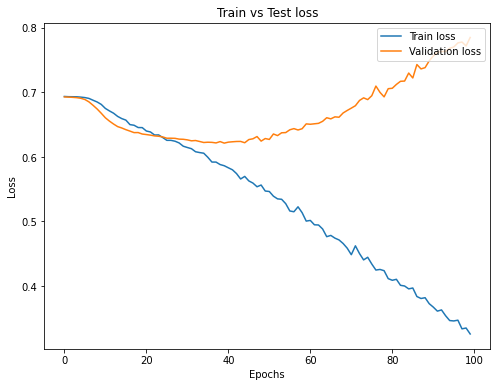

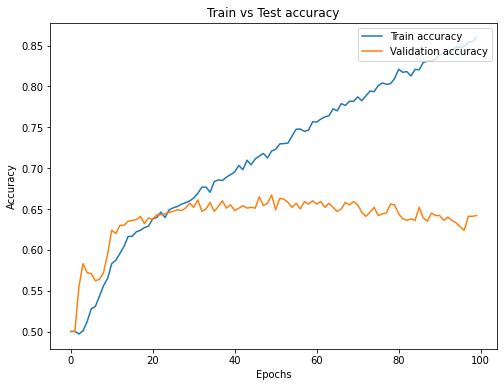

In [ ]:
plot_logs(histories, 'Train vs Test')

# Second approach (sequence encoding)

## Datasets and Dataloaders

In [ ]:
class MyDatasetRNN(torch.utils.data.Dataset):
    def __init__(self, dataset_path: str):
        # data_store used to build dataloader
        self.data_store = []
        with jsonlines.open(dataset_path) as f:
            for line in f:
                self.vectorize_line(line)
                ''' each line has this kind of structure:
                {
                  "id": "dev.24",
                  "lemma": "filthy",
                  "pos": "ADJ",
                  "sentence1": "They were given food in a filthy toilet without even minimal sanitary arrangements.",
                  "sentence2": "He spent a week in a filthy cell together with seven other detainees.",
                  "start1": "26",
                  "end1": "32",
                  "start2": "21",
                  "end2": "27",
                  "label": "True"
                }
                '''
    # line -> extract features and append to data_store 
    def vectorize_line(self, line):
        vector = []

        self.vectorize_sentence('sentence1', line, vector)    # vectorize and append first sentence
        vector.append(2)                                      # sentences separator
        self.vectorize_sentence('sentence2', line, vector)    # vectorize and append second sentence
 
        vector = torch.tensor(vector, dtype=torch.long)       # data as sequence of word indices
        label = 0 if(line['label'] == 'False') else 1

        self.data_store.append((vector, label))

    # sentence -> extract feature of single sentence
    def vectorize_sentence (self, sentence: str, line, vector):
        for word in line[sentence].strip().split(' '):
            # ignore these characters
            word = re.sub('[\.,:;!@#$\(\)\-&\\<>/0-9"”“]', '', word).lower()
            # consider only word of 4+ characters
            if len(word) > 3:
              vector.append(word_index[word])

    def __len__(self) -> int:
        return len(self.data_store)

    def __getitem__(self, idx: int) -> torch.Tensor:
        return self.data_store[idx]

In [ ]:
# COLLATE FUNCTION USED BY THE DATALOADER
# input: list of (x, y) pairs
# pad every vector to make them of same shape
# for instance, if length to reach is 10:
# ([30, 31, 32, 2, 40, 41, 42], 1) -> ([30, 31, 32, 2, 40, 41, 42, 0, 0, 0], 7, 1)
def rnn_collate_fn(data_elements: List[Tuple[torch.Tensor, torch.Tensor]]) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    X = [data_element[0] for data_element in data_elements]                    # list of index tensors
    X_lengths = torch.tensor([x.size(0) for x in X], dtype=torch.long)         # implement the many-to-one strategy
    X = torch.nn.utils.rnn.pad_sequence(X, batch_first=True, padding_value=0)  # 32 x max_seq_len
    y = torch.tensor([data_element[1] for data_element in data_elements])
    return X, X_lengths, y

In [ ]:
# Create training-validation datasets
train_dataset = MyDatasetRNN('/content/drive/MyDrive/nlp2021-hw1-main/data/train.jsonl')
validation_dataset = MyDatasetRNN('/content/drive/MyDrive/nlp2021-hw1-main/data/dev.jsonl')
# Create training-validation dataloaders
train_dataloaderRNN = DataLoader(train_dataset, batch_size=32, collate_fn=rnn_collate_fn)
validation_dataloaderRNN = DataLoader(validation_dataset, batch_size=32, collate_fn=rnn_collate_fn)

for batch in train_dataloaderRNN:
    X, vector_lengths, y = batch
    #print(X)
    print(f"batch X shape: {X.shape}")
    print(f"batch X words counts: {vector_lengths}")
    print(f"batch y shape: {y.shape}")
    break
    
for batch in validation_dataloaderRNN:
    X, vector_lengths, y = batch
    print('\n')
    print(f"batch X shape: {X.shape}")
    print(f"batch X words counts: {vector_lengths}")
    print(f"batch y shape: {y.shape}")
    break

batch X shape: torch.Size([32, 54])
batch X words counts: tensor([20, 25, 29, 21, 31, 30, 22, 30, 46, 30, 21, 24, 26, 29, 50, 30, 39, 40,
        29, 34, 36, 28, 29, 26, 44, 38, 25, 23, 53, 54, 20, 33])
batch y shape: torch.Size([32])


batch X shape: torch.Size([32, 38])
batch X words counts: tensor([38, 20, 14, 18, 24, 31, 29, 29, 33, 26, 19, 18, 34, 23, 18, 26, 26, 25,
        22, 19, 24, 22, 22, 19, 21, 24, 19, 22, 25, 31, 35, 37])
batch y shape: torch.Size([32])


## Training

In [ ]:
class MyClassifierRNN(torch.nn.Module):
    def __init__(self, vectors_store: torch.Tensor, n_hidden: int):
        super().__init__()
        self.n_hidden = n_hidden
        # Embedding layer
        self.embedding = torch.nn.Embedding.from_pretrained(vectors_store)
        # Recurrent layers (just to test some.. not all of them are used)
        self.lstm   = torch.nn.LSTM(input_size=vectors_store.size(1), hidden_size=vectors_store.size(1), num_layers=1, batch_first=True)
        self.bilstm = torch.nn.LSTM(input_size=vectors_store.size(1), hidden_size=vectors_store.size(1), num_layers=2, batch_first = True, bidirectional = True)
        # Linear layers
        self.lin1 = torch.nn.Linear(vectors_store.size(1), n_hidden)
        self.lin2 = torch.nn.Linear(n_hidden, 1)
        # Dropout layer
        self.drop = torch.nn.Dropout(0.5)
        # Binary classification task -> Binary cross-entropy loss function
        self.loss_fn = torch.nn.BCELoss()

    def forward(self, x: torch.Tensor, x_length: torch.Tensor, y: Optional[torch.Tensor] = None) -> Dict[str, torch.Tensor]:
        # Network structure
        out = self.embedding(x)
        out = self.drop(out)
        out, _  = self.bilstm(out)
        
        batch_size, sequence_size, hidden_size = out.shape                        # retrieve the last token output for each sequence
        out = out.reshape(-1, hidden_size)                                        # recurrent output flattened 32xhidden_size
        last_word_relative_indices = x_length - 1                                 # indices of the last token in each batch element
        if torch.cuda.is_available():
          last_word_relative_indices = last_word_relative_indices.cuda()
        sequences_offsets = torch.arange(batch_size) * sequence_size              # start offsets of each element in the batch
        if torch.cuda.is_available():
          sequences_offsets = sequences_offsets.cuda()
        out = out[sequences_offsets + last_word_relative_indices]                 # sum and retrieve the vectors that summarize every sentence pairs

        out = out[ :, :vectors_store.size(1)] + out[ :, vectors_store.size(1):]
        out = self.lin1(out)
        out = torch.relu(out)
        out = self.lin2(out).squeeze(1)
        # Binary classification task -> Sigmoid activation function
        out = torch.sigmoid(out)

        result = {'pred': out}

        # If we have labels, loss computation
        if y is not None:
            loss = self.loss(out, y)
            result['loss'] = loss

        return result

    def loss(self, pred, y):
        return self.loss_fn(pred, y)

In [ ]:
def training_loopRNN(model: nn.Module, optimizer: torch.optim.Optimizer,  adapt: Callable[[torch.Tensor, torch.Tensor], Tuple[torch.Tensor, torch.Tensor]], epochs: int = 5):
    # A good accuracy from where we start saving the model (-inf is also okay)
    max_valid_acc = 0.620
    # Histories to use in plotting
    train_acc_history = []
    train_loss_history = []
    val_acc_history = []
    val_loss_history = []

    for epoch in range(epochs):
      # TRAINING
      losses = []
      n = 0
      d = 0
      for x, l, y in train_dataloaderRNN:
          if torch.cuda.is_available():
              x, l, y = x.cuda(), l.cuda(), y.cuda()
          x, y = adapt(x, y)
          optimizer.zero_grad()
          batch_out = model(x, l, y)
          train_loss = batch_out['loss']
          losses.append(train_loss)
          train_pred = torch.round(batch_out['pred'])
          d += train_pred.shape[0]
          n += (y == train_pred).int().sum()
          # training step
          train_loss.backward()
          optimizer.step()
      # Metrics computation
      train_mean_loss = sum(losses)/len(losses)
      train_loss_history.append(train_mean_loss.item())
      train_accuracy = n/d
      train_acc_history.append(train_accuracy.item())

      # EPOCH VALIDATION
      losses = []
      n = 0
      d = 0
      model.eval()
      with torch.no_grad():
        for x, l, y in validation_dataloaderRNN:
            if torch.cuda.is_available():
                x, l, y = x.cuda(), l.cuda(), y.cuda()
            x, y = adapt(x, y)
            batch_out = model(x, l, y)
            val_loss = batch_out['loss']
            losses.append(val_loss)
            y = y > 0.5
            val_pred = torch.round(batch_out['pred'])
            d += val_pred.shape[0]
            n += (y == val_pred).int().sum()
      # Metrics computation
      val_mean_loss = sum(losses)/len(losses)
      val_loss_history.append(val_mean_loss.item())
      val_accuracy = n/d
      val_acc_history.append(val_accuracy.item())
      model.train()
      print(f'Epoch {epoch+1} \t Training Loss: {train_mean_loss:.4f} \t Training Accuracy: {train_accuracy:.3f} \t Validation Loss: {val_mean_loss:.4f} \t Validation Accuracy: {val_accuracy:.3f}')
      
      # Good validation accuracy -> we save this model
      if max_valid_acc < val_accuracy:
          print(f'Validation Accuracy Increased({max_valid_acc:.3f}--->{val_accuracy:.3f}) \t Saving The Model')
          # Update accuracy-to-beat value
          max_valid_acc = val_accuracy
          # Decrease learning rate using the scheduler
          scheduler.step()
          print('Learning rate is now ', optimizer.param_groups[0]['lr'])
          # Saving model state dict
          torch.save(model.state_dict(), 'saved_modelRNN.pt')
    return {
      'train_acc_history': train_acc_history,
      'train_loss_history': train_loss_history,
      'val_acc_history': val_acc_history,
      'val_loss_history': val_loss_history,
    }

In [ ]:
# Basic architectures were tested, resulting accuracy:
# lstm -> 0.615
# gru  -> 0.591
# rnn  -> 0.585
# Therefore I kept training only lstm based architectures

In [ ]:
# MAIN LOOP
# LSTM WITH DROPOUT, WITHOUT LR CHANGE (max_valid_acc reached here -> 0.618)
model = MyClassifierRNN(vectors_store, 64)
if torch.cuda.is_available():
    model = model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

historiesRNN = training_loopRNN(model, optimizer, adapt=lambda x, y : (x, (y > 0.5).float()), epochs = 200)

Epoch 1 	 Training Loss: 0.6936 	 Training Accuracy: 0.494 	 Validation Loss: 0.6928 	 Validation Accuracy: 0.539
Epoch 2 	 Training Loss: 0.6933 	 Training Accuracy: 0.495 	 Validation Loss: 0.6925 	 Validation Accuracy: 0.540
Epoch 3 	 Training Loss: 0.6928 	 Training Accuracy: 0.507 	 Validation Loss: 0.6921 	 Validation Accuracy: 0.530
Epoch 4 	 Training Loss: 0.6926 	 Training Accuracy: 0.510 	 Validation Loss: 0.6919 	 Validation Accuracy: 0.524
Epoch 5 	 Training Loss: 0.6921 	 Training Accuracy: 0.519 	 Validation Loss: 0.6914 	 Validation Accuracy: 0.522
Epoch 6 	 Training Loss: 0.6921 	 Training Accuracy: 0.517 	 Validation Loss: 0.6909 	 Validation Accuracy: 0.528
Epoch 7 	 Training Loss: 0.6914 	 Training Accuracy: 0.521 	 Validation Loss: 0.6906 	 Validation Accuracy: 0.530
Epoch 8 	 Training Loss: 0.6912 	 Training Accuracy: 0.525 	 Validation Loss: 0.6901 	 Validation Accuracy: 0.536
Epoch 9 	 Training Loss: 0.6905 	 Training Accuracy: 0.520 	 Validation Loss: 0.6896 	 V

In [ ]:
# MAIN LOOP
# BIDIRECTIONAL LSTM WITH DROPOUT, WITHOUT LR CHANGE (max_valid_acc reached here -> 0.639)
model = MyClassifierRNN(vectors_store, 64)
if torch.cuda.is_available():
    model = model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

historiesRNN = training_loopRNN(model, optimizer, adapt=lambda x, y : (x, (y > 0.5).float()), epochs = 200)

Epoch 1 	 Training Loss: 0.6940 	 Training Accuracy: 0.491 	 Validation Loss: 0.6932 	 Validation Accuracy: 0.500
Epoch 2 	 Training Loss: 0.6936 	 Training Accuracy: 0.495 	 Validation Loss: 0.6931 	 Validation Accuracy: 0.502
Epoch 3 	 Training Loss: 0.6935 	 Training Accuracy: 0.502 	 Validation Loss: 0.6931 	 Validation Accuracy: 0.503
Epoch 4 	 Training Loss: 0.6936 	 Training Accuracy: 0.496 	 Validation Loss: 0.6929 	 Validation Accuracy: 0.529
Epoch 5 	 Training Loss: 0.6932 	 Training Accuracy: 0.503 	 Validation Loss: 0.6928 	 Validation Accuracy: 0.519
Epoch 6 	 Training Loss: 0.6931 	 Training Accuracy: 0.500 	 Validation Loss: 0.6925 	 Validation Accuracy: 0.529
Epoch 7 	 Training Loss: 0.6930 	 Training Accuracy: 0.503 	 Validation Loss: 0.6924 	 Validation Accuracy: 0.522
Epoch 8 	 Training Loss: 0.6929 	 Training Accuracy: 0.511 	 Validation Loss: 0.6920 	 Validation Accuracy: 0.527
Epoch 9 	 Training Loss: 0.6923 	 Training Accuracy: 0.516 	 Validation Loss: 0.6911 	 V

In [ ]:
# MAIN LOOP
# BIDIRECTIONAL LSTM WITH DROPOUT, WITH LR CHANGE (max_valid_acc reached here -> 0.641)
model = MyClassifierRNN(vectors_store, 64)
if torch.cuda.is_available():
    model = model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

historiesRNN = training_loopRNN(model, optimizer, adapt=lambda x, y : (x, (y > 0.5).float()), epochs = 200)

Epoch 1 	 Training Loss: 0.6947 	 Training Accuracy: 0.491 	 Validation Loss: 0.6929 	 Validation Accuracy: 0.500
Epoch 2 	 Training Loss: 0.6938 	 Training Accuracy: 0.492 	 Validation Loss: 0.6928 	 Validation Accuracy: 0.503
Epoch 3 	 Training Loss: 0.6936 	 Training Accuracy: 0.487 	 Validation Loss: 0.6927 	 Validation Accuracy: 0.501
Epoch 4 	 Training Loss: 0.6933 	 Training Accuracy: 0.494 	 Validation Loss: 0.6927 	 Validation Accuracy: 0.517
Epoch 5 	 Training Loss: 0.6933 	 Training Accuracy: 0.497 	 Validation Loss: 0.6925 	 Validation Accuracy: 0.520
Epoch 6 	 Training Loss: 0.6932 	 Training Accuracy: 0.501 	 Validation Loss: 0.6924 	 Validation Accuracy: 0.522
Epoch 7 	 Training Loss: 0.6929 	 Training Accuracy: 0.504 	 Validation Loss: 0.6923 	 Validation Accuracy: 0.525
Epoch 8 	 Training Loss: 0.6926 	 Training Accuracy: 0.514 	 Validation Loss: 0.6919 	 Validation Accuracy: 0.530
Epoch 9 	 Training Loss: 0.6924 	 Training Accuracy: 0.513 	 Validation Loss: 0.6914 	 V

## Validation

In [ ]:
n = 0
d = 0
model = MyClassifierRNN(vectors_store, 64)
model.load_state_dict(torch.load('/content/drive/MyDrive/nlp2021-hw1-main/model/saved_modelRNN_0.641_bidirectional.pt', map_location=torch.device('cpu')))

# Accuracy computation
for x, l, y in validation_dataloaderRNN:
    y = y > 0.5   
    model.eval()
    with torch.no_grad():
        batch_out = model(x, l)
        pred = batch_out['pred']

    pred = torch.round(pred)
    d += pred.shape[0]
    n += (y == pred).int().sum()
print(f'# accuracy: {(n / d).item():.3f}')

# accuracy: 0.641


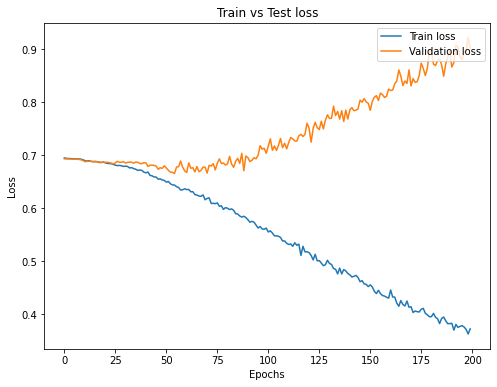

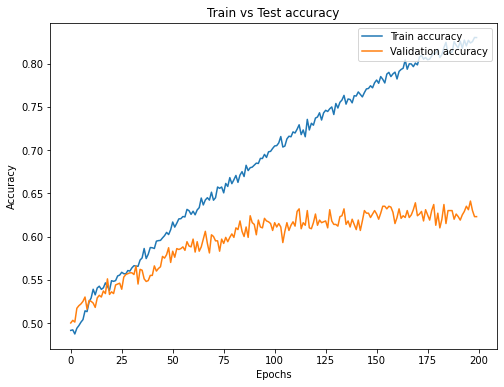

In [ ]:
plot_logs(historiesRNN, 'Train vs Test')